In [1]:
import sys, os
import numpy as np
import time, h5py
codepath = '/user_data/mmhender/imStat/code'
sys.path.append(codepath)
from utils import default_paths, nsd_utils, numpy_utils, stats_utils
from model_fitting import initialize_fitting 
import argparse
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import scipy.stats

from plotting import load_fits

In [2]:

subject =1;
discrim_type_list =['animacy','indoor_outdoor', 'person', 'animal','food','vehicle']
corr_result_list = [];
dprime_result_list = [];
which_prf_grid = 5

path_to_load = default_paths.gabor_texture_feat_path
fn1 = os.path.join(path_to_load, 'S%d_mean_grid%d.npy'%(subject, which_prf_grid))
fn2 = os.path.join(path_to_load, 'S%d_var_grid%d.npy'%(subject, which_prf_grid))
fn3 = os.path.join(path_to_load, 'S%d_covar_grid%d.npy'%(subject, which_prf_grid))
print('loading from %s and %s and %s'%(fn1, fn2, fn3))
mean_result = np.load(fn1,allow_pickle=True)
var_result = np.load(fn2,allow_pickle=True)
covar_result = np.load(fn3,allow_pickle=True)
path_to_load = os.path.join(path_to_load, 'semantic_discrim')
for dd, discrim_type in enumerate(discrim_type_list):
    fn1 = os.path.join(path_to_load, 'S%d_corrs_%s_grid%d.npy'%(subject, discrim_type, which_prf_grid))
    fn2 = os.path.join(path_to_load, 'S%d_dprime_%s_grid%d.npy'%(subject, discrim_type, which_prf_grid))
    print('loading from %s and %s'%(fn1, fn2))
    corr_result = np.load(fn1,allow_pickle=True)
    dprime_result = (-1)*np.load(fn2,allow_pickle=True)
    corr_result_list.append(corr_result)
    dprime_result_list.append(dprime_result)
    corr_result=None; dprime_result=None

loading from /user_data/mmhender/features/gabor_texture/S1_mean_grid5.npy and /user_data/mmhender/features/gabor_texture/S1_var_grid5.npy and /user_data/mmhender/features/gabor_texture/S1_covar_grid5.npy
loading from /user_data/mmhender/features/gabor_texture/semantic_discrim/S1_corrs_animacy_grid5.npy and /user_data/mmhender/features/gabor_texture/semantic_discrim/S1_dprime_animacy_grid5.npy
loading from /user_data/mmhender/features/gabor_texture/semantic_discrim/S1_corrs_indoor_outdoor_grid5.npy and /user_data/mmhender/features/gabor_texture/semantic_discrim/S1_dprime_indoor_outdoor_grid5.npy
loading from /user_data/mmhender/features/gabor_texture/semantic_discrim/S1_corrs_person_grid5.npy and /user_data/mmhender/features/gabor_texture/semantic_discrim/S1_dprime_person_grid5.npy
loading from /user_data/mmhender/features/gabor_texture/semantic_discrim/S1_corrs_animal_grid5.npy and /user_data/mmhender/features/gabor_texture/semantic_discrim/S1_dprime_animal_grid5.npy
loading from /user

In [4]:

subject = 1
volume_space=True
fitting_type = 'gabor_solo_ridge_12ori_8sf'
# fitting_type='gabor_pca_max100dim'

root = os.path.dirname(os.path.dirname(os.getcwd()))
out, fig_save_folder = load_fits.load_fit_results(subject, volume_space, fitting_type, \
                                                  n_from_end=0, root=root, verbose=True);
# load_fits.print_output_summary(out)

w = out['best_params'][1][:,:,0]

feature_corrs = out['corr_each_feature']

cyc_per_stim = np.array(out['feature_table_complex']['SF: cycles per stim'])
# cyc_per_stim = np.unique(cyc_per_stim)
screen_eccen_deg=8.4
cyc_per_deg = cyc_per_stim/screen_eccen_deg
sf_vals_cyc_per_deg, sf_inds = np.unique(cyc_per_deg, return_inverse=True)

orients_deg = np.array(out['feature_table_complex']['Orientation: degrees'])
orient_vals_deg, orient_inds = np.unique(orients_deg, return_inverse=True)

feature_weights = out['best_params'][1][:,:,0]
feature_corr = out['corr_each_feature']
n_voxels = feature_weights.shape[0]
n_ori = len(np.unique(orients_deg))
n_sf = len(np.unique(cyc_per_stim))

allw_reshaped = np.reshape(feature_weights, [n_voxels, n_ori, n_sf], order='F')
mean_orient_weights = np.mean(allw_reshaped, axis=2)
print(np.shape(mean_orient_weights))
mean_sf_weights = np.mean(allw_reshaped, axis=1)
print(np.shape(mean_sf_weights))

allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
print(np.shape(mean_orient_corr))
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)
print(np.shape(mean_sf_corr))

# find maxes. if they are constant across orient/SF, then set to nan.
preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_orient_corr[:,0:1], [1,n_ori])==mean_orient_corr, axis=1)
preferred_ori_corr[is_constant] = np.nan

preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_sf_corr[:,0:1], [1,n_sf])==mean_sf_corr, axis=1)
preferred_sf_corr[is_constant] = np.nan

preferred_ori_weights = np.argmax(mean_orient_weights, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_orient_weights[:,0:1], [1,n_ori])==mean_orient_weights, axis=1)
preferred_ori_weights[is_constant] = np.nan

preferred_sf_weights = np.argmax(mean_sf_weights, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_sf_weights[:,0:1], [1,n_sf])==mean_sf_weights, axis=1)
preferred_sf_weights[is_constant] = np.nan

loading from /user_data/mmhender/imStat/model_fits/S01/gabor_solo_ridge_12ori_8sf/Dec-10-2021_1208_11/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'zscore_in_groups', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'saved_prfs_fn', 'best_layer_each_voxel', 'saved_best_layer_fn', 'corr_each_feature', 'discrim_each_axis', 'feature_table_simple', 'filter_pars_simple', 'orient_filters_simple', 'feature_table_complex', 'filter_pars_complex', 'orient_filters_complex', 'feature_types_exclude', 'gabor_feature_info', 'autocorr_output_pix', 'group_all_hl_feats', 'gabor_nonlin_fn'])
(19738, 12)
(19738, 8)
(19738, 12)
(19738, 8)


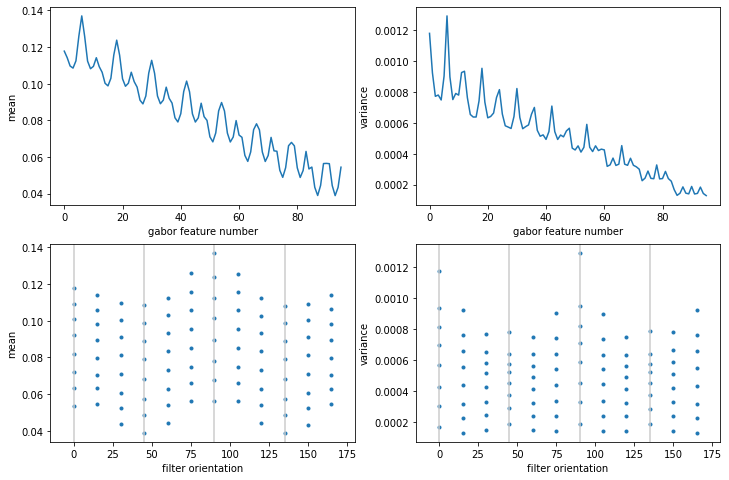

In [5]:

plt.figure(figsize=(12,8));

plt.subplot(2,2,1)
plt.plot(np.mean(mean_result, axis=1)[0:150])
plt.xlabel('gabor feature number');
plt.ylabel('mean');
plt.subplot(2,2,2)
plt.plot(np.mean(var_result, axis=1)[0:150])
plt.xlabel('gabor feature number');
plt.ylabel('variance');

   
plt.subplot(2,2,3)
plt.plot(orients_deg, np.mean(mean_result, axis=1),'.')
plt.xlabel('filter orientation');
plt.ylabel('mean');
plt.xlim([-15, 180])
for ii in np.arange(0,180,45):
    plt.axvline(ii, color=[0.8, 0.8, 0.8])

plt.subplot(2,2,4)
plt.plot(orients_deg, np.mean(var_result, axis=1),'.')
plt.xlabel('filter orientation');
plt.ylabel('variance');
plt.xlim([-15, 180])
for ii in np.arange(0,180,45):
    plt.axvline(ii, color=[0.8, 0.8, 0.8])

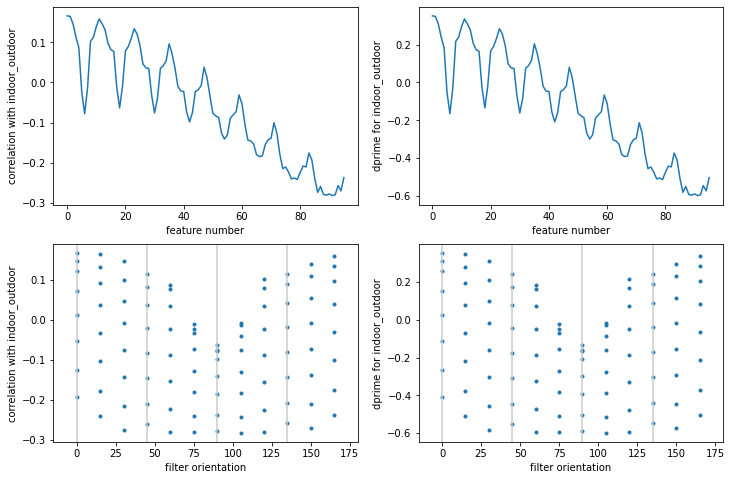

In [6]:
dd = 1;

plt.figure(figsize=(12,8));

plt.subplot(2,2,1)
plt.plot(np.mean(corr_result_list[dd], axis=1))
plt.xlabel('feature number');
plt.ylabel('correlation with %s'%discrim_type_list[dd]);
plt.subplot(2,2,2)
plt.plot(np.mean(dprime_result_list[dd], axis=1))
plt.xlabel('feature number');
plt.ylabel('dprime for %s'%discrim_type_list[dd]);


plt.subplot(2,2,3)
plt.plot(orients_deg, np.mean(corr_result_list[dd], axis=1),'.')
plt.xlabel('filter orientation');
plt.ylabel('correlation with %s'%discrim_type_list[dd]);
plt.xlim([-15, 180])
for ii in np.arange(0,180,45):
    plt.axvline(ii, color=[0.8, 0.8, 0.8])
    
plt.subplot(2,2,4)
plt.plot(orients_deg, np.mean(dprime_result_list[dd], axis=1),'.')
plt.xlabel('filter orientation');
plt.ylabel('dprime for %s'%discrim_type_list[dd]);
plt.xlim([-15, 180])
for ii in np.arange(0,180,45):
    plt.axvline(ii, color=[0.8, 0.8, 0.8])

 
 

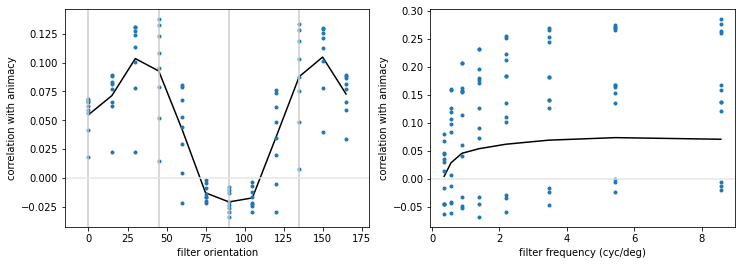

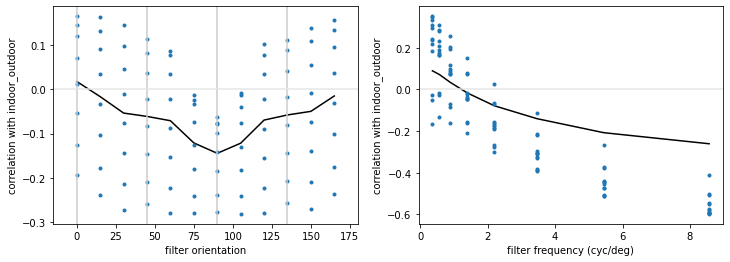

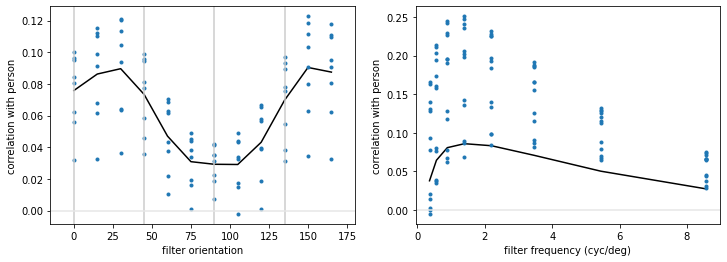

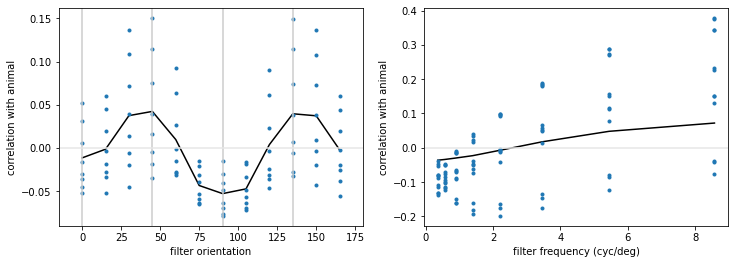

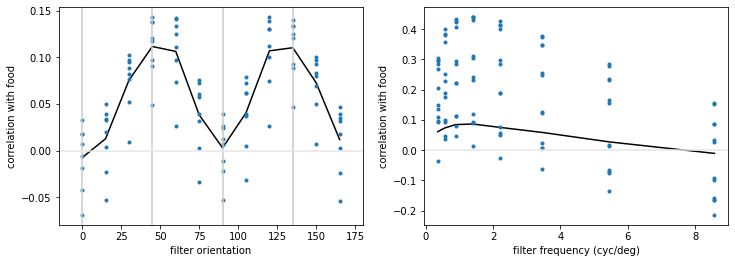

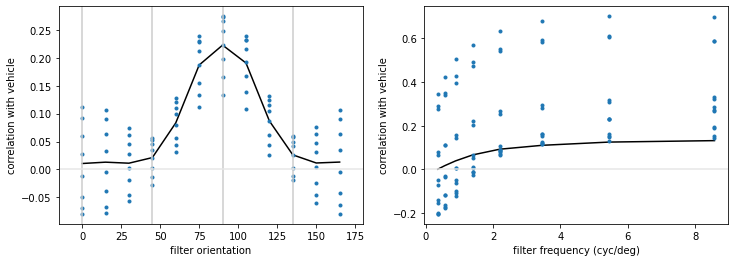

In [7]:
for dd in range(len(discrim_type_list)):

    plt.figure(figsize=(12,4));
    plt.subplot(1,2,1)
    mean_each_orient = np.mean(np.reshape(np.mean(corr_result_list[dd], axis=1), [n_sf, n_ori]), axis=0);
    plt.plot(orient_vals_deg, mean_each_orient,color='k')
    plt.plot(orients_deg, np.mean(corr_result_list[dd], axis=1),'.')
    plt.xlabel('filter orientation');
    plt.ylabel('correlation with %s'%discrim_type_list[dd]);
    plt.xlim([-15, 180])
    for ii in np.arange(0,180,45):
        plt.axvline(ii, color=[0.8, 0.8, 0.8])
    plt.axhline(0, color=[0.9, 0.9, 0.9])

    plt.subplot(1,2,2)
    mean_each_sf = np.mean(np.reshape(np.mean(corr_result_list[dd], axis=1), [n_sf, n_ori]), axis=1);
    plt.plot(sf_vals_cyc_per_deg, mean_each_sf,color='k')
    plt.plot(cyc_per_deg, np.mean(dprime_result_list[dd], axis=1),'.')
    plt.xlabel('filter frequency (cyc/deg)');
    plt.ylabel('correlation with %s'%discrim_type_list[dd]);
    # plt.xlim([-15, 180])
    plt.axhline(0, color=[0.9, 0.9, 0.9]);

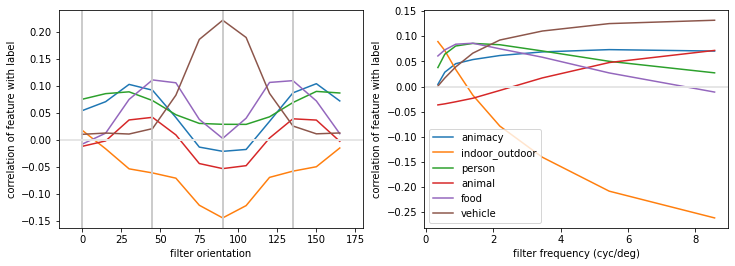

In [8]:
plt.figure(figsize=(12,4));
lh = []
for dd in range(len(discrim_type_list)):

    
    plt.subplot(1,2,1)
    mean_each_orient = np.mean(np.reshape(np.mean(corr_result_list[dd], axis=1), [n_sf, n_ori]), axis=0);
    plt.plot(orient_vals_deg, mean_each_orient)   
    plt.xlabel('filter orientation');
    plt.xlim([-15, 180])
    for ii in np.arange(0,180,45):
        plt.axvline(ii, color=[0.8, 0.8, 0.8])
    plt.axhline(0, color=[0.9, 0.9, 0.9])
    plt.ylabel('correlation of feature with label')
    
    ax = plt.subplot(1,2,2)
    mean_each_sf = np.mean(np.reshape(np.mean(corr_result_list[dd], axis=1), [n_sf, n_ori]), axis=1);
    l, = ax.plot(sf_vals_cyc_per_deg, mean_each_sf)
    lh.append(l)
    plt.xlabel('filter frequency (cyc/deg)');
    plt.axhline(0, color=[0.9, 0.9, 0.9]);
    plt.ylabel('correlation of feature with label')
    
plt.legend(lh, discrim_type_list)

Text(0, 0.5, 'Correlation of feature with encoding model response')

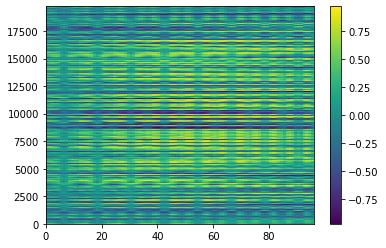

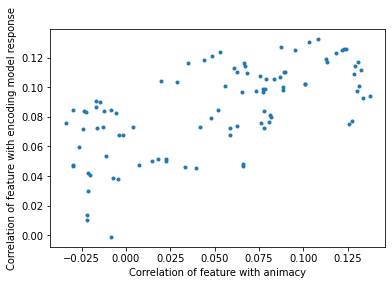

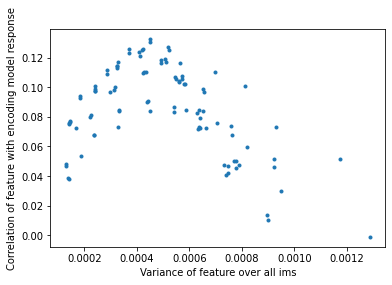

In [65]:
dd = 0;


plt.figure();
plt.pcolormesh(feature_corrs)
plt.colorbar()

plt.figure();
plt.plot(np.mean(corr_result_list[dd], axis=1)[0:150], np.mean(feature_corrs, axis=0), '.')
plt.xlabel('Correlation of feature with %s'%discrim_type_list[dd])
plt.ylabel('Correlation of feature with encoding model response')

plt.figure();
plt.plot(np.mean(var_result, axis=1)[0:150], np.mean(feature_corrs, axis=0), '.')
plt.xlabel('Variance of feature over all ims')
plt.ylabel('Correlation of feature with encoding model response')

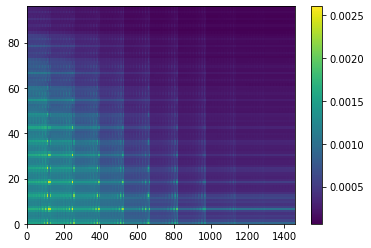

In [9]:
plt.figure();
plt.pcolormesh(var_result[0:150,:])
plt.colorbar()

Text(0.5, 0.98, 'Covariance of gabor features, across entire image set\n(averaged over pRFs)')

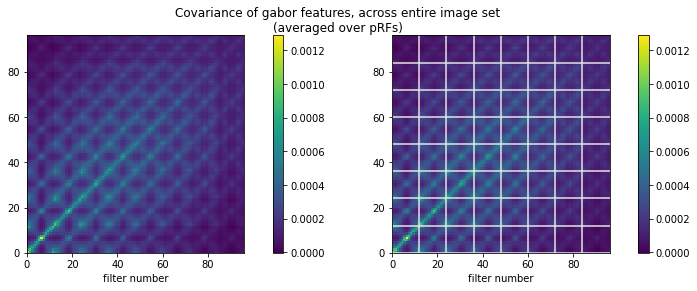

In [18]:
plt.figure(figsize=(12,4));

plt.subplot(1,2,1)
plt.pcolormesh(np.mean(covar_result, axis=2))
plt.colorbar()
plt.axis('square')
plt.xlabel('filter number')
plt.xlabel('filter number')

plt.subplot(1,2,2)
plt.pcolormesh(np.mean(covar_result, axis=2))
plt.colorbar()
plt.axis('square')
plt.xlabel('filter number')
plt.xlabel('filter number')
for ii in range(n_sf):
    plt.axvline(ii*n_ori, color=[0.9, 0.9, 0.9])
    plt.axhline(ii*n_ori, color=[0.9, 0.9, 0.9])
    
plt.suptitle('Covariance of gabor features, across entire image set\n(averaged over pRFs)')

In [19]:
from utils import roi_utils
roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=True,volume_space=True,verbose=False) 
skip_inds = [10,11,15,23]
retlabs, facelabs, placelabs, bodylabs, \
        ret_names, face_names, place_names, body_names = roi_def
roi_names = ret_names+face_names+place_names+body_names
nret = len(ret_names)
nface = len(face_names)
nplace = len(place_names)
nbody = len(body_names)    
n_rois = len(ret_names) + len(face_names) + len(place_names) + len(body_names)

is_ret = np.arange(0, n_rois)<nret
is_face = (np.arange(0, n_rois)>=nret) & (np.arange(0, n_rois)<nret+nface)
is_place = (np.arange(0, n_rois)>=nret+nface) & (np.arange(0, n_rois)<nret+nface+nplace)
is_body = np.arange(0, n_rois)>=nret+nface+nplace


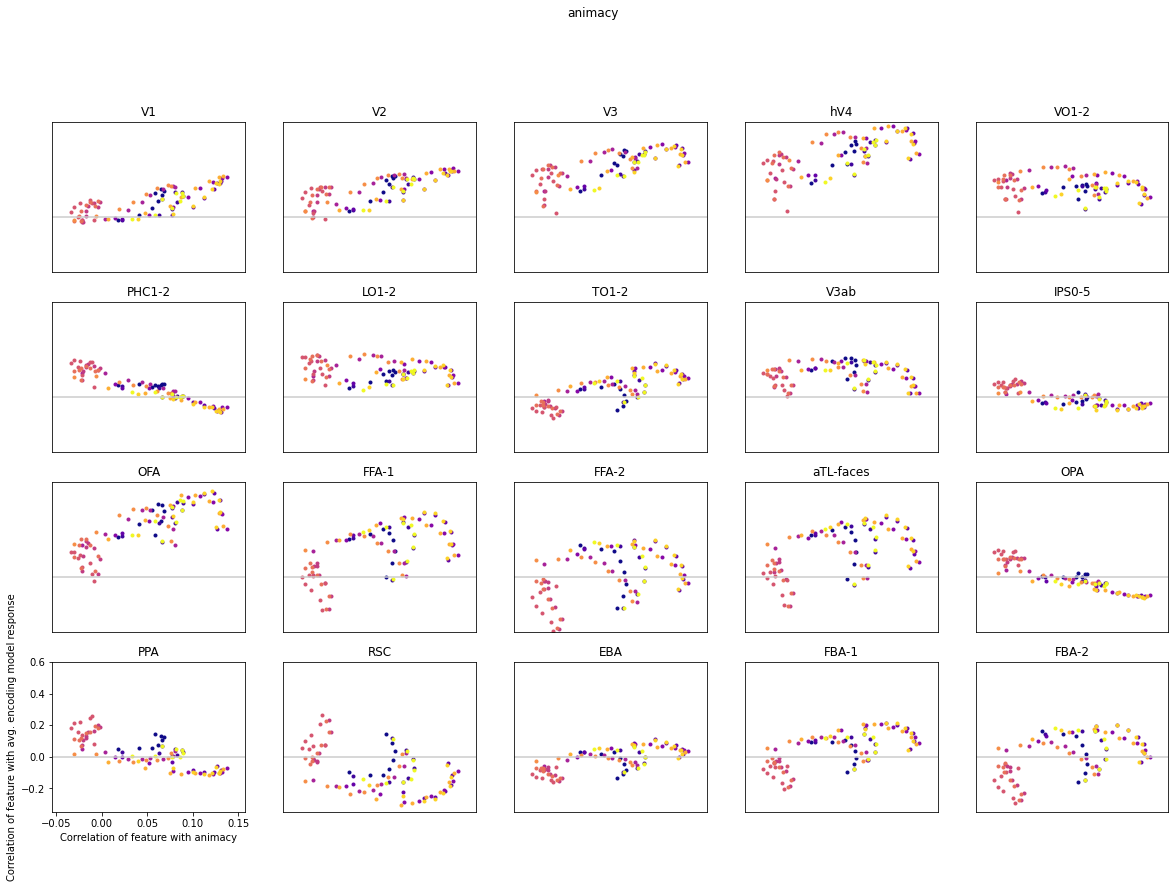

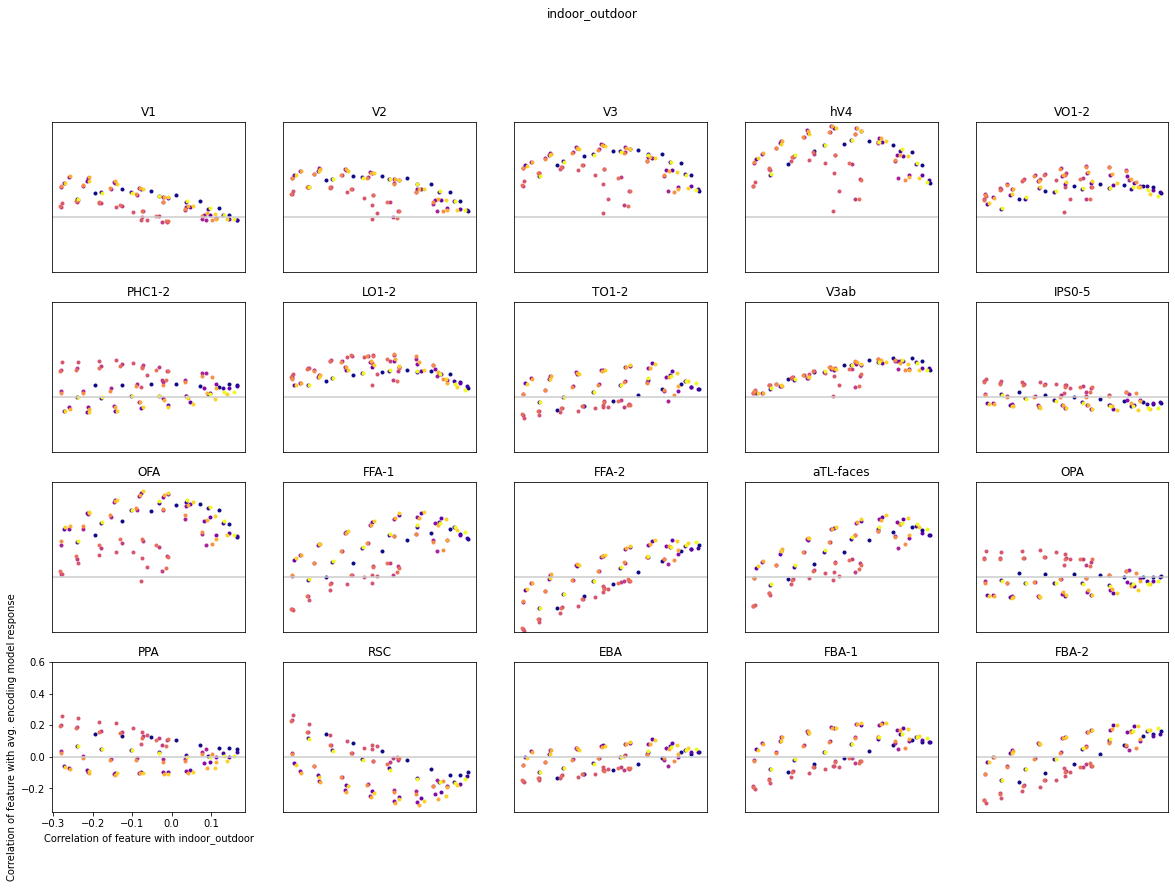

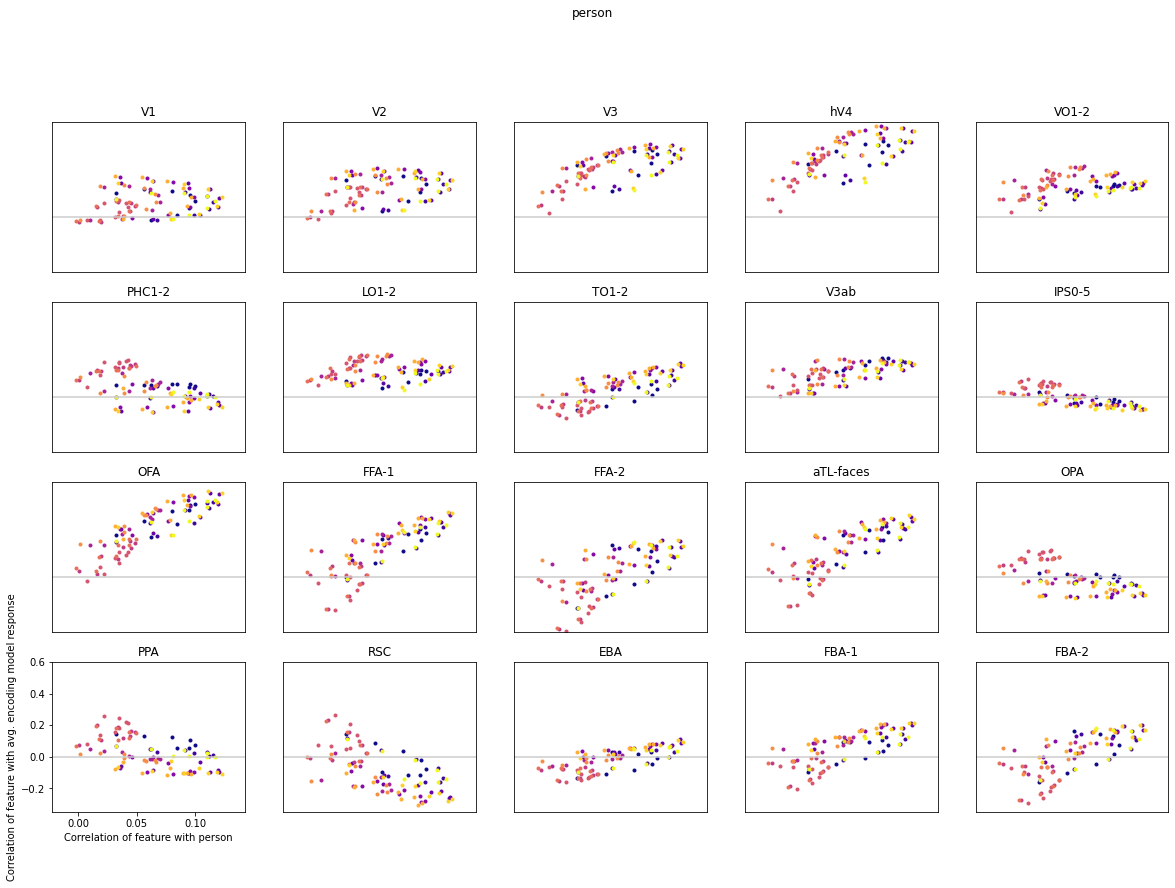

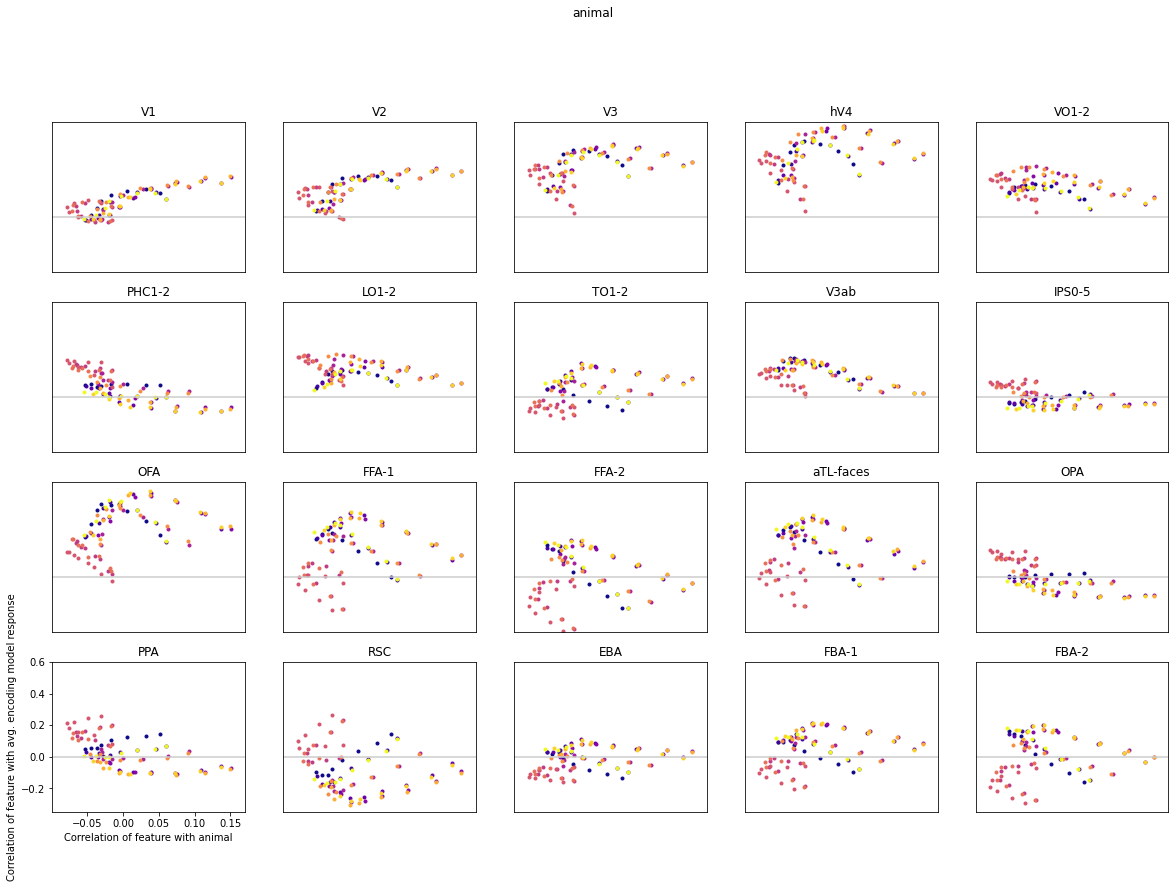

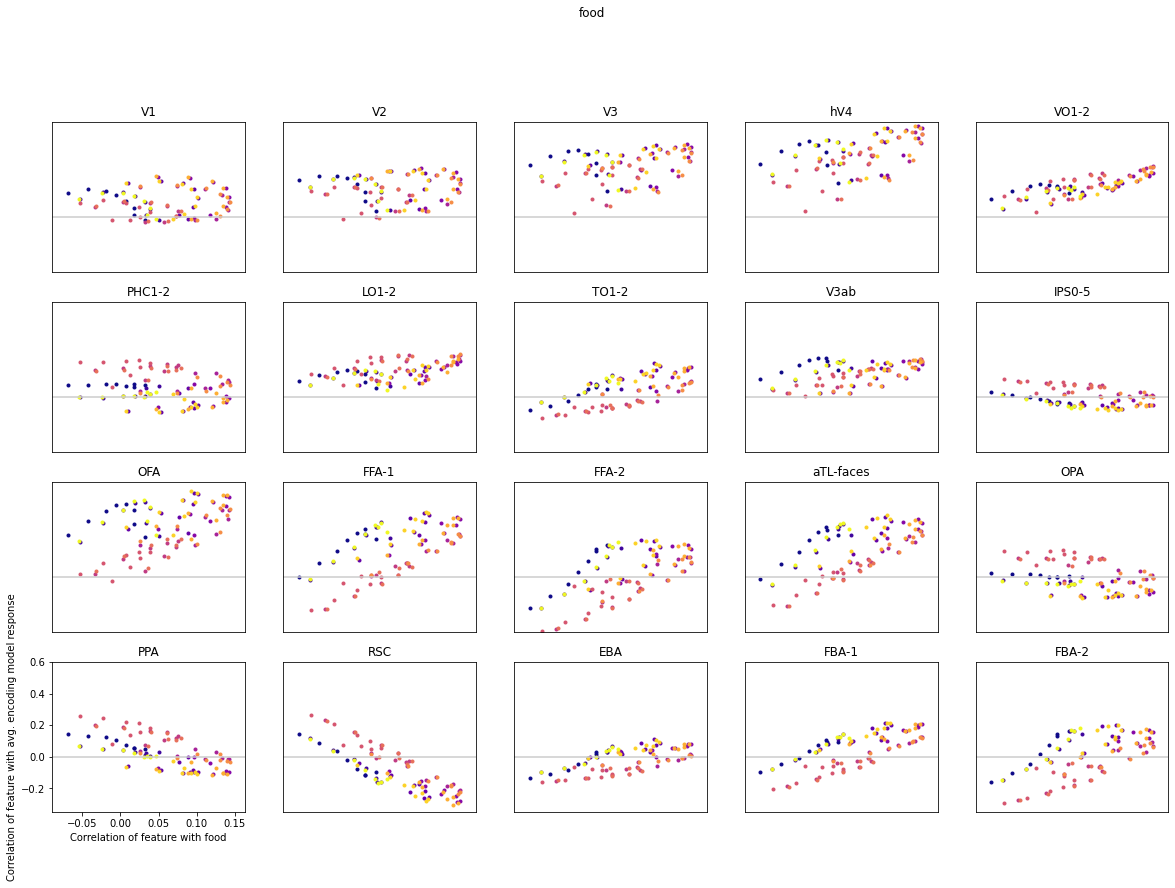

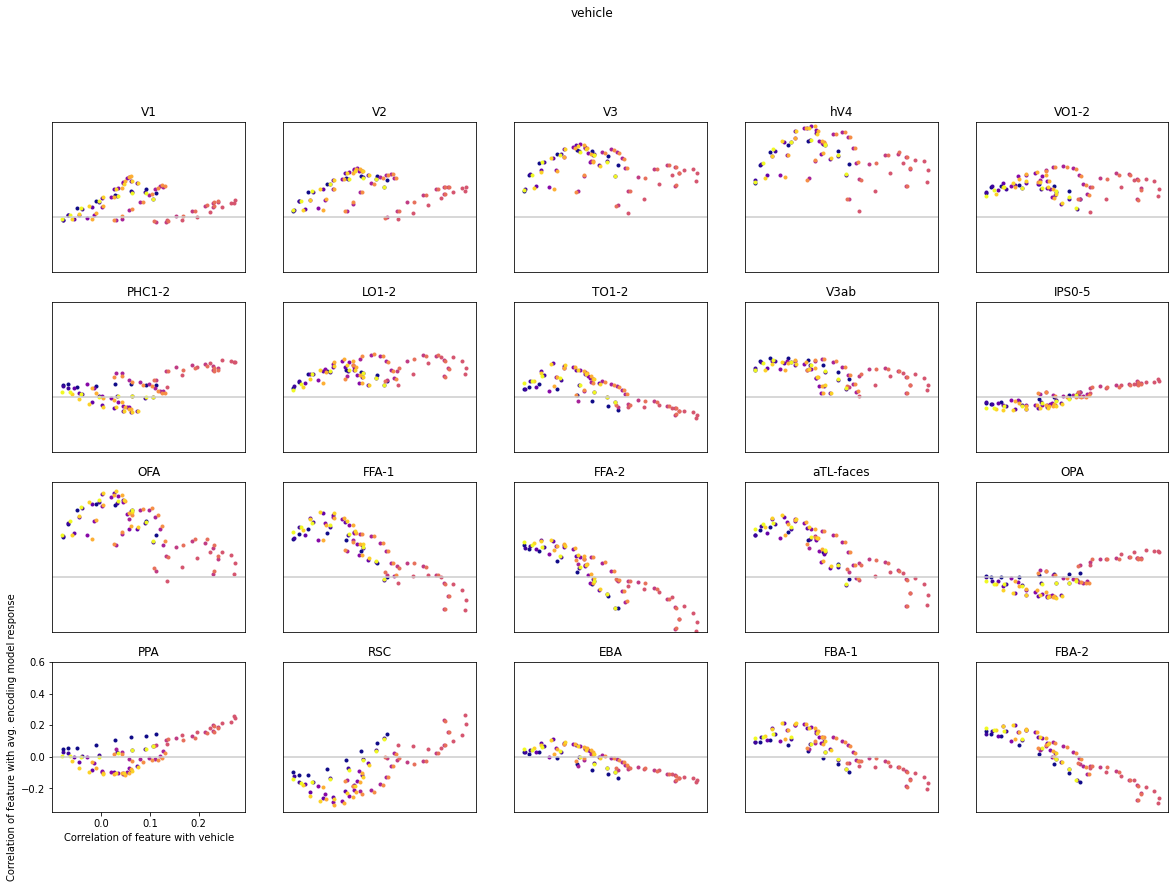

In [20]:
for dd in range(len(discrim_type_list)):

    xlims = [np.min(np.mean(corr_result_list[dd], axis=1))-0.02, \
             np.max(np.mean(corr_result_list[dd], axis=1))+0.02]
    ylims = [-0.35, 0.6]

    n_color_steps = n_ori
    colors = cm.plasma(np.linspace(0,1,n_color_steps))

    plt.figure(figsize=(20,16))
    npx = int(np.ceil(np.sqrt(n_rois)))
    npy = int(np.ceil(n_rois/npx))

    pi=0
    running_xmin=100; running_ymin=100;
    running_xmax=-100; running_ymax=-100;
    for rr in range(n_rois):

        if rr not in skip_inds:
            if is_ret[rr]:
                inds_this_roi = retlabs==rr
                rname = ret_names[rr]
            elif is_face[rr]:
                inds_this_roi = facelabs==(rr-nret)
                rname = face_names[rr-nret]
            elif is_place[rr]:
                inds_this_roi = placelabs==(rr-nret-nface)
                rname = place_names[rr-nret-nface]
            elif is_body[rr]:
                inds_this_roi = bodylabs==(rr-nret-nface-nplace)
                rname = body_names[rr-nret-nface-nplace]

            pi+=1
            plt.subplot(npx,npy,pi)
            xvals = np.mean(corr_result_list[dd], axis=1)
            yvals = np.mean(feature_corrs[inds_this_roi,:], axis=0)
            running_xmin = np.min([running_xmin, np.min(xvals)])
            running_ymin = np.min([running_ymin, np.min(yvals)])
            running_xmax = np.max([running_xmax, np.max(xvals)])
            running_ymax = np.max([running_ymax, np.max(yvals)])

            for oo in range(n_ori):
                inds = np.where(orient_inds==oo)[0]
                plt.plot(xvals[inds], yvals[inds],'.',color=colors[oo,:])
            if pi==n_rois-8:
                plt.xlabel('Correlation of feature with %s'%discrim_type_list[dd])
                plt.ylabel('Correlation of feature with avg. encoding model response')
            else:
                plt.xticks([])
                plt.yticks([])

            plt.axhline(0,color=[0.8, 0.8, 0.8])
            plt.title(rname)
            plt.xlim(xlims)
            plt.ylim(ylims)

#     print([running_xmin, running_xmax])
#     print([running_ymin, running_ymax])

    plt.suptitle(discrim_type_list[dd]);

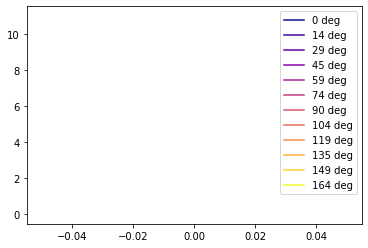

In [87]:
plt.figure();
for oo in range(n_ori):
    plt.plot(0,oo,color=colors[oo,:])    
plt.legend(['%d deg'%orient_vals_deg[oo] for oo in range(n_ori)])

[0.00012841033458244056, 0.0012888727942481637]
[-0.34091347571136643, 0.5779598144668877]


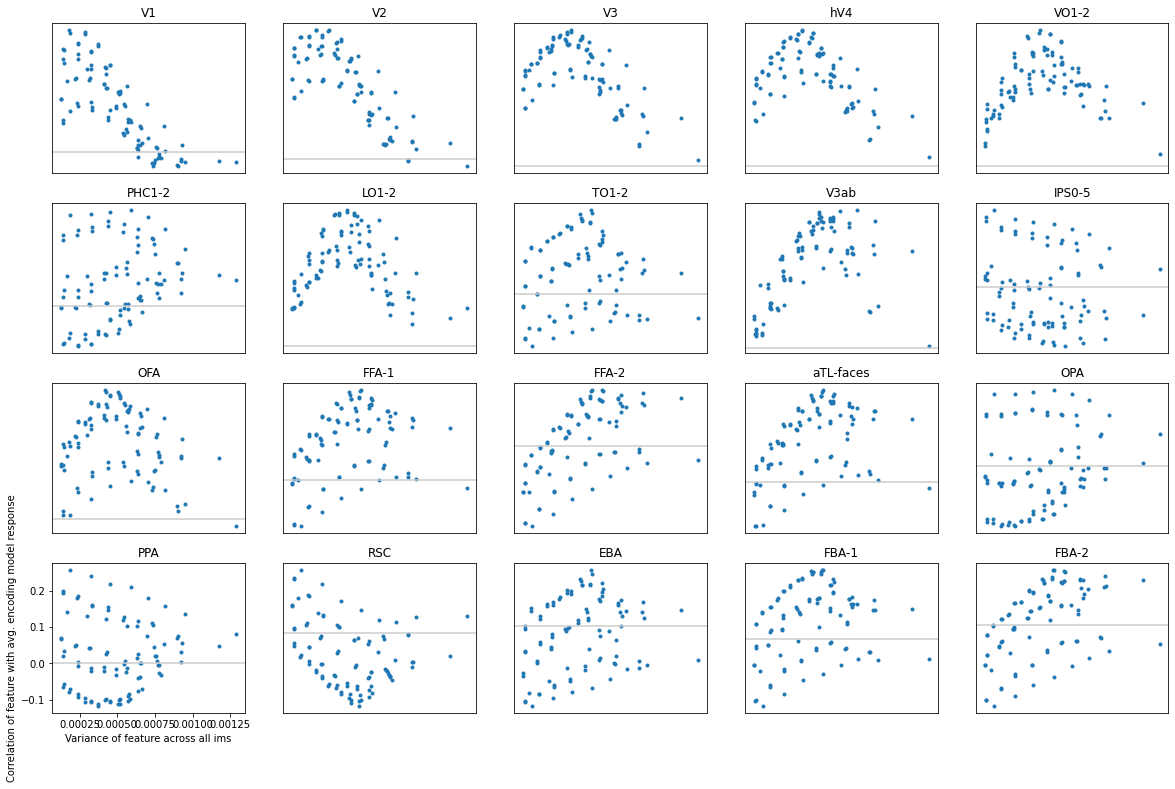

In [28]:

plt.figure(figsize=(20,16))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

pi=0
running_xmin=100; running_ymin=100;
running_xmax=-100; running_ymax=-100;
for rr in range(n_rois):

    if rr not in skip_inds:
        if is_ret[rr]:
            inds_this_roi = retlabs==rr
            rname = ret_names[rr]
        elif is_face[rr]:
            inds_this_roi = facelabs==(rr-nret)
            rname = face_names[rr-nret]
        elif is_place[rr]:
            inds_this_roi = placelabs==(rr-nret-nface)
            rname = place_names[rr-nret-nface]
        elif is_body[rr]:
            inds_this_roi = bodylabs==(rr-nret-nface-nplace)
            rname = body_names[rr-nret-nface-nplace]

        pi+=1
        plt.subplot(npx,npy,pi)
        xvals = np.mean(var_result, axis=1)[0:150]
        yvals = np.mean(feature_corrs[inds_this_roi,:], axis=0)
        running_xmin = np.min([running_xmin, np.min(xvals)])
        running_ymin = np.min([running_ymin, np.min(yvals)])
        running_xmax = np.max([running_xmax, np.max(xvals)])
        running_ymax = np.max([running_ymax, np.max(yvals)])
        
        plt.plot(xvals, yvals,'.')
        if pi==n_rois-8:
            plt.xlabel('Variance of feature across all ims');
            plt.ylabel('Correlation of feature with avg. encoding model response');
        else:
            plt.xticks([])
            plt.yticks([])

        plt.title(rname)
#         plt.xlim([0, 7e-07])
#         plt.ylim([-0.43, 0.6])
        plt.axhline(0, color=[0.8, 0.8, 0.8])
        
print([running_xmin, running_xmax])
print([running_ymin, running_ymax])


number of pRFs: 1456
most extreme RF positions:
[2.7755576e-17 0.0000000e+00 2.0000000e-02]
[ 0.7698996  -0.31890285  1.        ]


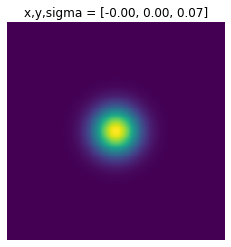

In [99]:
# To build more intuition going to load a few images and plot those that have highest activation for 
# a given feature type. Can get an idea of what image components these features relate to. 

from utils import prf_utils
which_prf_grid=5
models = initialize_fitting.get_prf_models(which_grid=which_prf_grid)
n_prfs = len(models)
mm = 400

x,y,sigma = models[mm,:]
n_pix = 240
prf_2d = prf_utils.gauss_2d(center=[x,y], sd=sigma, patch_size=n_pix)

plt.figure();
plt.pcolormesh(prf_2d)
plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()
plt.title('x,y,sigma = [%.2f, %.2f, %.2f]'%(x,y,sigma));

In [100]:
ims2use = np.arange(0,1000)

In [101]:
subject=1
n_ori = 12; n_sf = 8;
features_file = os.path.join(default_paths.gabor_texture_feat_path, \
                                'S%d_features_each_prf_%dori_%dsf_gabor_solo_nonlin_grid%d.h5py'%\
                                 (subject,n_ori, n_sf, which_prf_grid))
print('loading from %s'%features_file)
t = time.time()
with h5py.File(features_file, 'r') as data_set:
    values = np.copy(data_set['/features'][ims2use,:,mm])
    data_set.close() 
elapsed = time.time() - t
print('Took %.5f seconds to load file'%elapsed)
print(values.shape)

features_in_prf = values

loading from /user_data/mmhender/features/gabor_texture/S1_features_each_prf_12ori_8sf_gabor_solo_nonlin_grid5.h5py
Took 2.56612 seconds to load file
(1000, 96)


In [102]:
image_data = nsd_utils.get_image_data(subject)
image_data = nsd_utils.image_uncolorize_fn(image_data)
image_data = image_data[ims2use,:,:,:]


Loading images for subject 1

image data size: (10000, 3, 240, 240) , dtype: uint8 , value range: 0 255


In [107]:
labels_folder = os.path.join(default_paths.stim_labels_root, \
                     'S%d_within_prf_grid%d'%(subject,which_prf_grid))
coco_labels_fn = os.path.join(labels_folder, \
                      'S%d_cocolabs_binary_prf%d.csv'%(subject, mm))
coco_df = pd.read_csv(coco_labels_fn, index_col=0)


In [109]:
dd = 0

if discrim_type_list[dd]=='animacy':
    labels = np.array(coco_df['has_animate']).astype(np.float32)
else:
    labels = np.array(coco_df[discrim_type]).astype(np.float32)
ims_to_use = np.any(np.array(coco_df)[:,0:12]==1, axis=1)
labels[~ims_to_use] = np.nan
neach = [np.sum(labels==ll) for ll in np.unique(labels[~np.isnan(labels)])] + \
        [np.sum(np.isnan(labels))]
print('yes %s/no %s/no labels:'%(discrim_type_list[dd], discrim_type_list[dd]))
print(neach)
unvals = np.unique(labels[ims_to_use])                               
print('unique values:')
print(unvals)    

labels_trn = labels[ims2use]
inds2use = ~np.isnan(labels_trn) 
inds1 = (labels_trn==0) & inds2use
inds2 = (labels_trn==1) & inds2use

yes animacy/no animacy/no labels:
[3565, 5264, 1171]
unique values:
[0. 1.]


In [ ]:
oo = 5;
sf = 3;
ff = np.where((orient_inds==oo) & (sf_inds==sf))[0][0]

print('%d deg, %.3f cyc/deg'%(orients_deg[ff], cyc_per_deg[ff]))

zvals = scipy.stats.zscore(features_in_prf[:,ff])
feature_im = np.real(out['orient_filters_complex'][oo,0,:,:])

plt.figure(figsize=(2,2));
plt.pcolormesh(feature_im)
plt.gca().invert_yaxis()
plt.axis('off')
# plt.axis('square')
plt.suptitle('orient=%d, freq=%.3f cpd'%(orient_vals_deg[oo], sf_vals_cyc_per_deg[sf]))

top_n = 5
top_image_inds = np.flip(np.argsort(zvals))[0:top_n]
bottom_image_inds = np.argsort(zvals)[0:top_n]
top_resp = zvals[top_image_inds]
bottom_resp = zvals[bottom_image_inds]
top_images = image_data[top_image_inds,0,:,:]
bottom_images = image_data[bottom_image_inds,0,:,:]

center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

plt.figure(figsize=(18,6));
for ii in range(top_n):
    ax = plt.subplot(2,top_n,ii+1);
    plt.imshow(top_images[ii,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('act=%.2f, %s=%.0f'%(top_resp[ii], discrim_type_list[dd], labels_trn[top_image_inds[ii]]))
for ii in range(top_n):
    ax = plt.subplot(2,top_n,ii+1+top_n);    
    plt.imshow(bottom_images[ii,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('act=%.2f, %s=%.0f'%(bottom_resp[ii], discrim_type_list[dd], labels_trn[bottom_image_inds[ii]]))


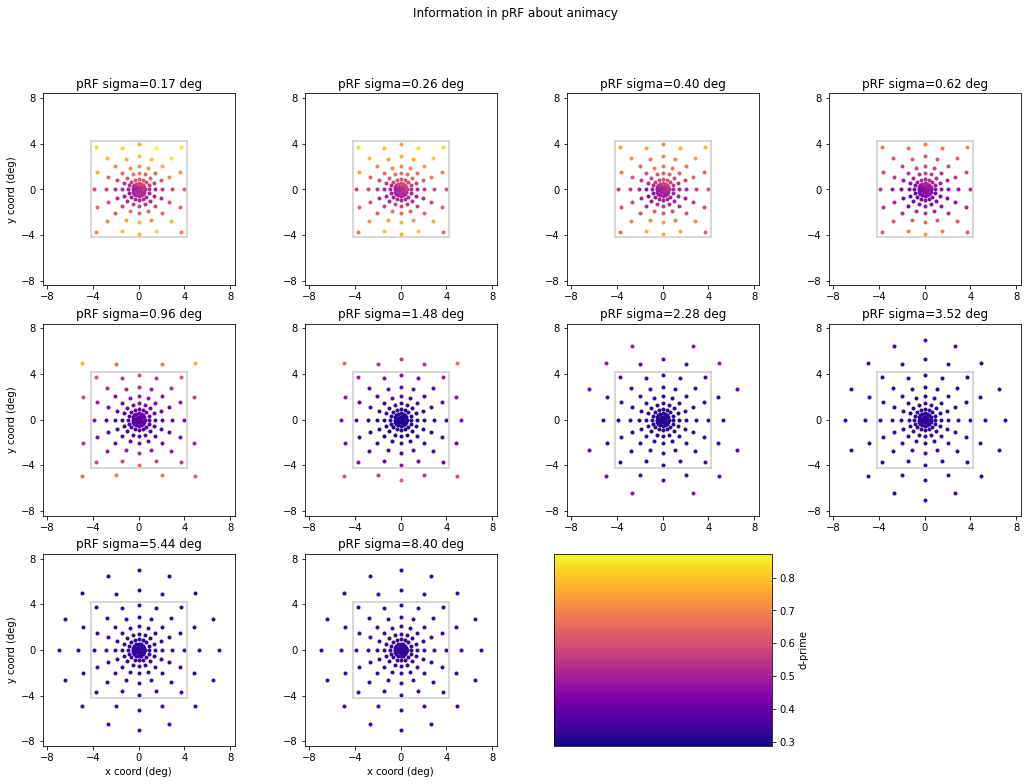

In [64]:
prf_models = models

unique_sizes = np.unique(np.round(prf_models[:,2],4))

fig = plt.figure(figsize=(18,12));

n_color_steps = 100
colors = cm.plasma(np.linspace(0,1,n_color_steps))
min_dprime = -0.5
dprime_vals = np.mean(dprime_result, axis=0)
# dprime_vals = np.max(dprime_result, axis=0)
dprime_range = [np.min(dprime_vals[dprime_vals>min_dprime]), \
                np.max(dprime_vals[dprime_vals>min_dprime])]
# dprime_range = [0, 1.4]
dprime_steps = np.linspace(dprime_range[0], dprime_range[1], n_color_steps)
screen_eccen_deg = 8.4
xylims = 1.0*screen_eccen_deg

for si, size in enumerate(unique_sizes):

    inds = np.where(np.round(prf_models[:,2],4)==size)[0]

    prf_models_plot = models[inds,:]
    dprime_plot = dprime_vals[inds]
    inds2plot = np.where(dprime_plot>min_dprime)[0]
    
    plt.subplot(3,4,si+1)
    ax = plt.gca()
        
    for mm in inds2plot:
        x,y,sigma = prf_models_plot[mm,:]
        dprime = dprime_plot[mm]
        color_ind = np.argmin(np.abs(dprime_steps-dprime))
        plt.plot(x*screen_eccen_deg,y*screen_eccen_deg,'.', color=colors[color_ind,:])  
        
    plt.axis('square')
    plt.xlim([-xylims, xylims])
    plt.ylim([-xylims, xylims])
    plt.xticks(np.arange(-8,9,4))
    plt.yticks(np.arange(-8,9,4))
    
    plt.plot([screen_eccen_deg/2,screen_eccen_deg/2], [screen_eccen_deg/2, -screen_eccen_deg/2],color=[0.8, 0.8, 0.8])
    plt.plot([-screen_eccen_deg/2,-screen_eccen_deg/2], [screen_eccen_deg/2, -screen_eccen_deg/2],color=[0.8, 0.8, 0.8])
    plt.plot([-screen_eccen_deg/2,screen_eccen_deg/2], [screen_eccen_deg/2, screen_eccen_deg/2],color=[0.8, 0.8, 0.8])
    plt.plot([-screen_eccen_deg/2,screen_eccen_deg/2], [-screen_eccen_deg/2, -screen_eccen_deg/2],color=[0.8, 0.8, 0.8])

    if si>7:
        plt.xlabel('x coord (deg)')
    if np.mod(si,4)==0:
        plt.ylabel('y coord (deg)')

    plt.title('pRF sigma=%.2f deg'%(size*screen_eccen_deg))
    
ax = plt.subplot(3,4,si+2)
scalmap = cm.ScalarMappable(matplotlib.colors.Normalize(vmin=dprime_range[0], vmax=dprime_range[1]),\
                  cmap='plasma')
fig.colorbar(scalmap, orientation='vertical', label='d-prime',cax=ax)

plt.suptitle('Information in pRF about %s'%discrim_type);

Text(0.5, 0.98, 'Number of voxels all areas with this pRF')

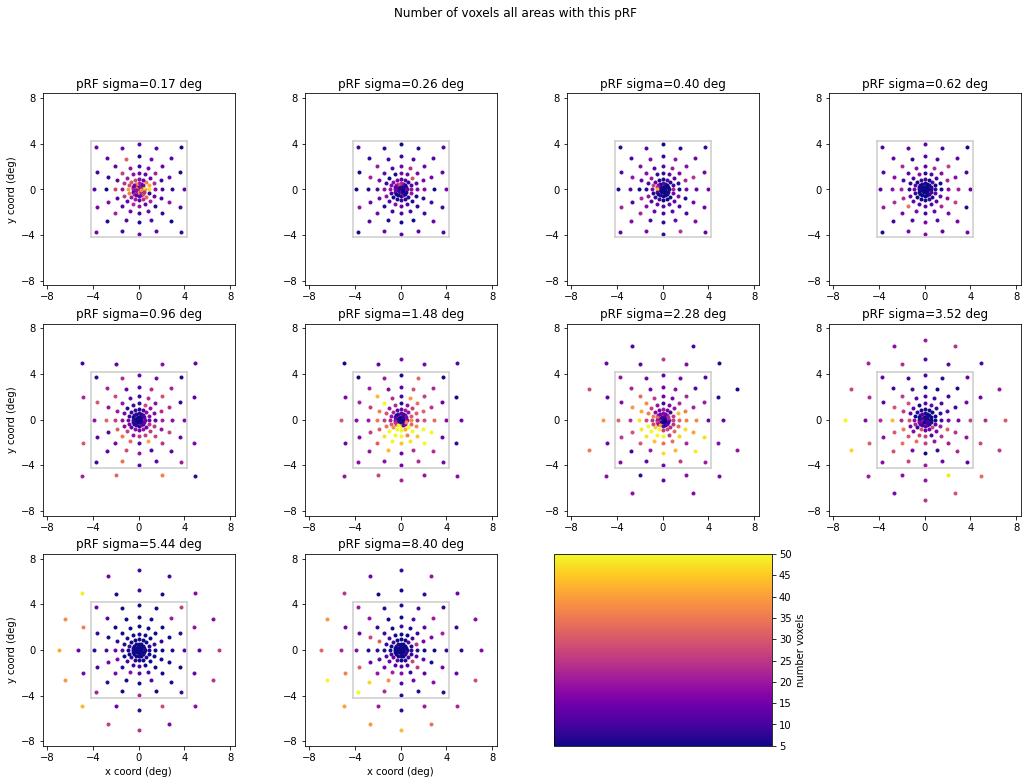

In [65]:
prf_models = models
neach = np.array([np.sum(out['best_params'][5][:,0]==mm) for mm in range(n_prfs)])
unique_sizes = np.unique(np.round(prf_models[:,2],4))

fig = plt.figure(figsize=(18,12));

n_color_steps = np.max(neach)
colors = cm.plasma(np.linspace(0,1,n_color_steps))
# vals_range = [np.min(neach), \
#                 np.max(neach)]
vals_range = [5,50]
vals_steps = np.linspace(vals_range[0], vals_range[1], n_color_steps)
screen_eccen_deg = 8.4
xylims = 1.0*screen_eccen_deg

for si, size in enumerate(unique_sizes):

    inds = np.where(np.round(prf_models[:,2],4)==size)[0]

    prf_models_plot = models[inds,:]
    vals_plot = neach[inds]
#     dprime_plot = np.array(lda_result['val_dprime'])[inds]
    plt.subplot(3,4,si+1)
    ax = plt.gca()
        
    for mm in range(len(prf_models_plot)):
        x,y,sigma = prf_models_plot[mm,:]
#         dprime = dprime_plot[mm]
        val = vals_plot[mm]
        color_ind = np.argmin(np.abs(vals_steps-val))
#         print(colors[color_ind,:])
        plt.plot(x*screen_eccen_deg,y*screen_eccen_deg,'.', color=colors[color_ind,:])  
        
    plt.axis('square')
    plt.xlim([-xylims, xylims])
    plt.ylim([-xylims, xylims])
    plt.xticks(np.arange(-8,9,4))
    plt.yticks(np.arange(-8,9,4))
    
    plt.plot([screen_eccen_deg/2,screen_eccen_deg/2], [screen_eccen_deg/2, -screen_eccen_deg/2],color=[0.8, 0.8, 0.8])
    plt.plot([-screen_eccen_deg/2,-screen_eccen_deg/2], [screen_eccen_deg/2, -screen_eccen_deg/2],color=[0.8, 0.8, 0.8])
    plt.plot([-screen_eccen_deg/2,screen_eccen_deg/2], [screen_eccen_deg/2, screen_eccen_deg/2],color=[0.8, 0.8, 0.8])
    plt.plot([-screen_eccen_deg/2,screen_eccen_deg/2], [-screen_eccen_deg/2, -screen_eccen_deg/2],color=[0.8, 0.8, 0.8])

    if si>7:
        plt.xlabel('x coord (deg)')
    if np.mod(si,4)==0:
        plt.ylabel('y coord (deg)')

    plt.title('pRF sigma=%.2f deg'%(size*screen_eccen_deg))
    
ax = plt.subplot(3,4,si+2)
scalmap = cm.ScalarMappable(matplotlib.colors.Normalize(vmin=vals_range[0], vmax=vals_range[1]),\
                  cmap='plasma')
fig.colorbar(scalmap, orientation='vertical', label='number voxels',cax=ax)

plt.suptitle('Number of voxels all areas with this pRF')

In [61]:
dprime_result.shape

(96, 1456)